##Importing Libraries and Data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product

from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')
import datetime

In [2]:
df = pd.read_csv('energydata_complete.csv')

Changing the data to include hourly increments

In [3]:
df = df[::6]

## Exploratory Data Analysis

Plotting initial trends of columns

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333



Dropping Irrelevant Columns

In [5]:
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)

In [6]:
df.shape

(3290, 26)

## Feature Engineering

Checking for Monthly and/or Daily Seasonality

Text(0.5, 0, 'Frequency')

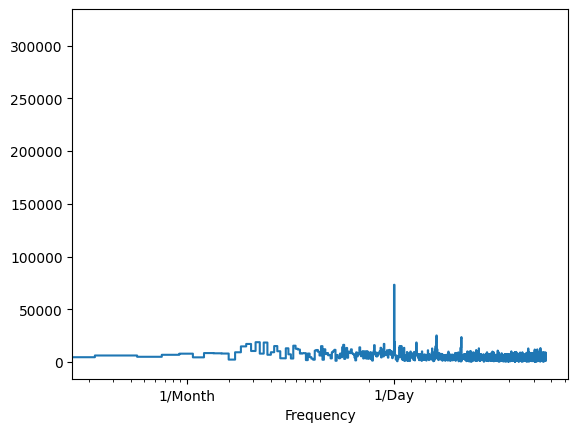

In [7]:
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h / hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/Month', '1/Day'])
plt.xlabel('Frequency')

## Statistical Models

SARIMAX

1. Making Data Stationary

In [8]:
stat_train_data = df.copy()

In [10]:
stat_train_data['Appliances'] = (stat_train_data['Appliances']).diff()

stat_train_data.head()

,date,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,NaN,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,...,18.200000,48.90,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3
6,2016-01-11 18:00:00,0.0,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,...,18.100000,48.59,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7
12,2016-01-11 19:00:00,370.0,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,...,18.066667,48.56,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6
18,2016-01-11 20:00:00,-350.0,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,...,18.533333,50.20,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1
24,2016-01-11 21:00:00,30.0,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,...,19.000000,49.76,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9


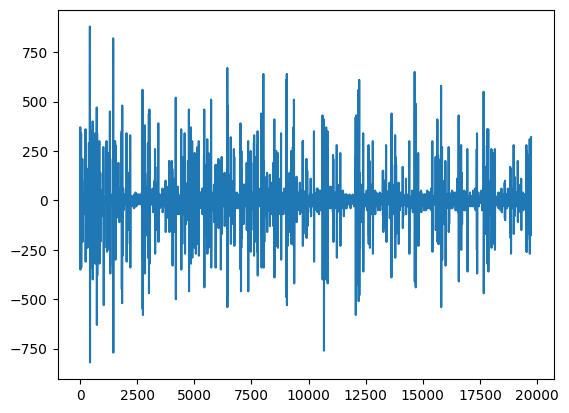

In [11]:
plt.plot(stat_train_data['Appliances'])

Applying ad fuller test to ensure stationarity

In [12]:
ad_fuller_result = adfuller(stat_train_data['Appliances'][2:])

print(f'Ad fuller test statistic: {ad_fuller_result[0]}')
print(f'Ad fuller P-Value: {ad_fuller_result[1]}')

Ad fuller test statistic: -17.30155523385806
Ad fuller P-Value: 5.6246707574011296e-30


Plotting the auto correlation and partial auto correlation functions

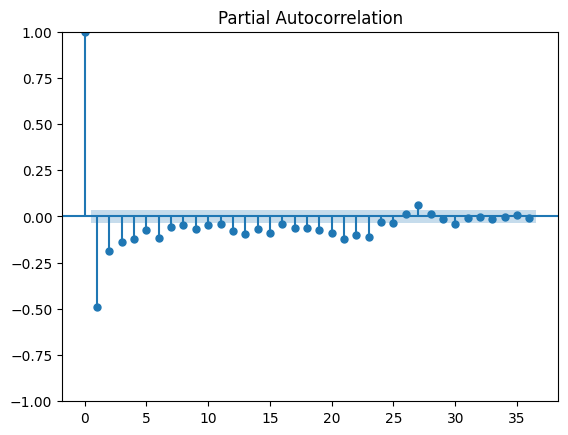

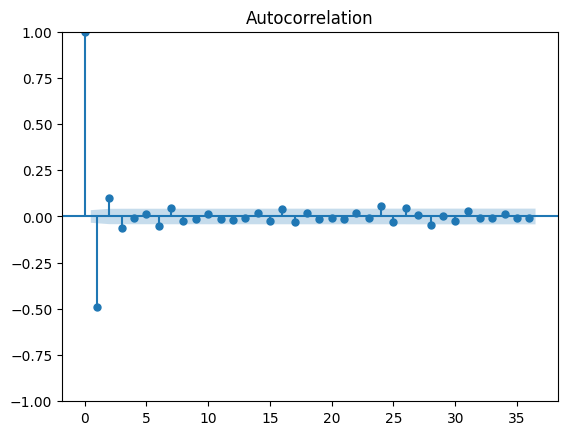

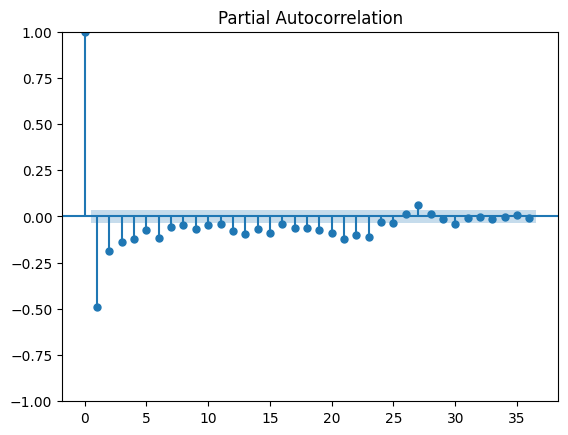

In [13]:
plot_acf(stat_train_data['Appliances'][1:])
plot_pacf(stat_train_data['Appliances'][1:])

Creating function to find best parameters for model

In [14]:
def optimize_SARIMAX(endog, exog, parameters_list, d, D, s):

  results = []

  for param in tqdm_notebook(parameters_list):
    try:
      model = SARIMAX(endog, exog, order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
    except:
      continue

    aic = model.aic
    results.append([param, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q) X (P,Q)', 'AIC']
  result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

  return result_df

In [15]:
p = range(0,3,1)
d = 1
q = range(0,3,1)
P = range(0,3,1)
D = 0
Q = range(0,3,1)
s = 24

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [16]:
len(parameters_list)

81

In [17]:
stat_train_data.columns.tolist()

['date',
 'Appliances',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint']

In [18]:
endog = stat_train_data['Appliances']
exog = stat_train_data[[
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 ]]
#result_df = optimize_SARIMAX(endog, exog, parameters_list, 1, 0, 24)
#result_df

Best Combination is 0,1,0,0

In [19]:
best_model = SARIMAX(endog, exog, order=(0,1,1),
                     seasonal_order=(0,0,0,24),
                     simple_differencing=False)

res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             Appliances   No. Observations:                 3290
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -20402.152
Date:                Mon, 10 Jul 2023   AIC                          40856.304
Time:                        10:38:30   BIC                          41014.861
Sample:                             0   HQIC                         40913.070
                               - 3290                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
T1             20.4455      6.043      3.383      0.001       8.602      32.289
RH_1            1.4375      1.967      0.731      0.465      -2.418       5.293
T2             -9.2013      5.654     -1.627    

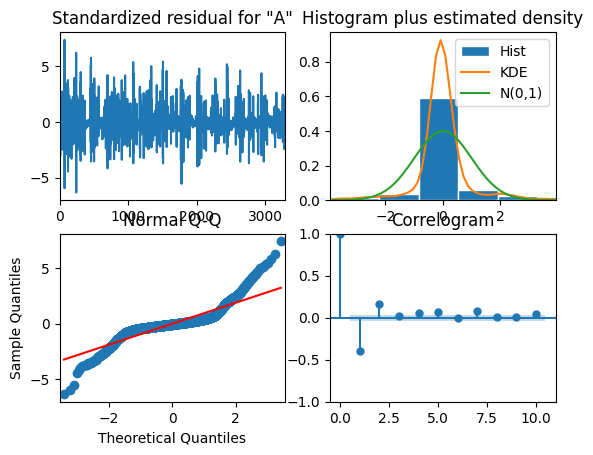

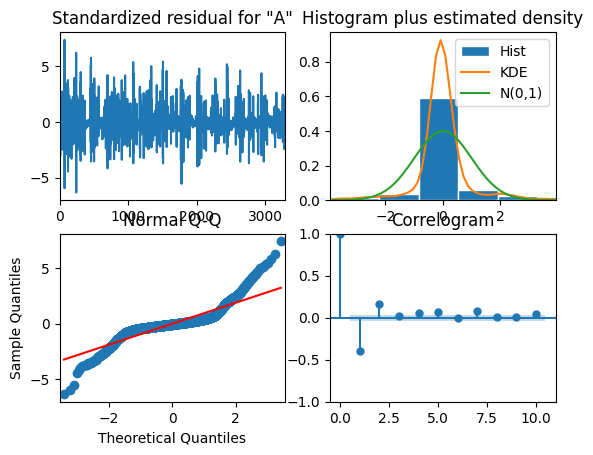

In [20]:
res.plot_diagnostics()

Making future predictions

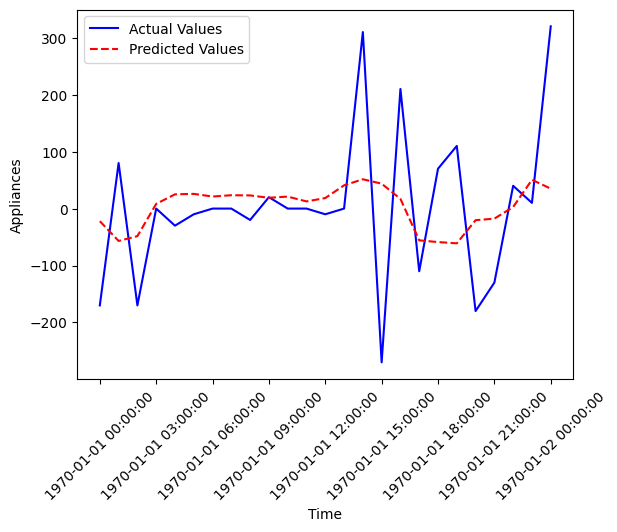

In [23]:
import matplotlib.dates as mdates

actual_values = stat_train_data['Appliances'][-25:]
predicted_values = predict_mean[-25:]

time_index = pd.date_range(start=actual_values.index[0], periods=len(actual_values), freq='H')

fig, ax = plt.subplots()
ax.plot(time_index, actual_values, color='blue', label='Actual Values')
ax.plot(time_index, predicted_values, color='red', linestyle='--', label='Predicted Values')

date_formatter = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation=45)

ax.set_xlabel('Time')
ax.set_ylabel('Appliances')
ax.legend()


plt.show()

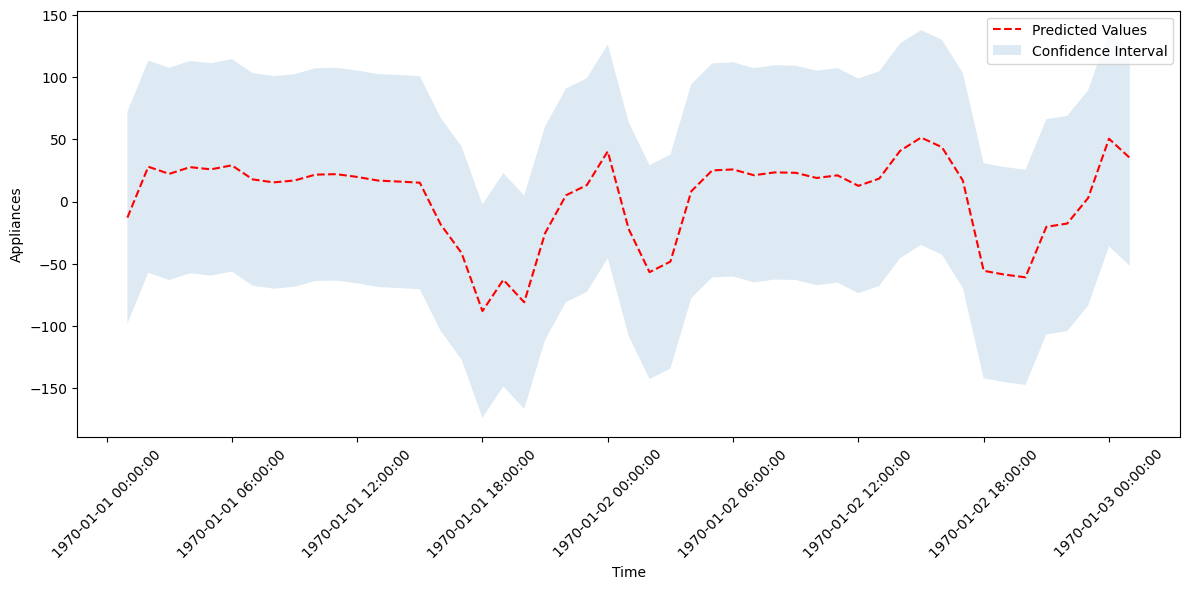

In [29]:
n_forecast = 49

predict = res.get_prediction(end=best_model.nobs + n_forecast, exog=exog.iloc[-50:])
predict_mean = predict.predicted_mean
predict_ci = predict.conf_int(alpha=0.5)

time_index = pd.date_range(start=actual_values.index[-1], periods=n_forecast+1, freq='H')[1:]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_index, predict_mean[-n_forecast:], color='red', linestyle='--', label='Predicted Values')
ax.fill_between(time_index, predict_ci.iloc[-n_forecast:, 0], predict_ci.iloc[-n_forecast:, 1], alpha=0.15, label='Confidence Interval')

ax.set_xlabel('Time')
ax.set_ylabel('Appliances')
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

Calculating Performance

In [30]:
actual_values = stat_train_data['Appliances'][-n_forecast:]

mse = mean_squared_error(actual_values, predict_mean[-n_forecast:])

print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 16612.188686744263
